In [25]:
import pandas as pd
from datetime import datetime, timedelta
!pip install geopandas
!pip install gtfs_functions
from gtfs_functions import Feed, map_gdf
import datetime

In [26]:
from gtfs_functions import Feed, map_gdf

In [27]:
# Load GTFS data into DataFrames
feed = Feed(r'C:\Users\sd\OneDrive\Indicateur TC\GTFS_recent.zip',time_windows=[0, 6, 9, 15, 19, 22, 24], busiest_date= False)
calendar_df = feed.calendar_dates
stop_times_df = feed.stop_times
routes_df = feed.routes


INFO:root:Reading "calendar_dates.txt".
INFO:root:get trips in stop_times
INFO:root:accessing trips
INFO:root:Reading "routes.txt".
INFO:root:Reading "trips.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:Reading "stop_times.txt".
INFO:root:computing patterns
INFO:root:Reading "stop_times.txt".


In [28]:
# Merge the data to have the dates on it
merged_data = pd.merge(stop_times_df, calendar_df, on='service_id')

# Convert all dates to a consistent format (e.g., YYYY-MM-DD)
merged_data['date'] = pd.to_datetime(merged_data['date'], format='%Y%m%d', errors='coerce')


# If we want to differentiate between metro and bus merged_data = pd.merge(merged_data, routes_df, on='route_id')
# If you want to see the departure and arrivale time more clear
#merged_data['arrival_time'] = pd.to_datetime(merged_data['arrival_time'],unit='s',origin=pd.Timestamp('2023-08-06'),format='%Y-%m-%d')
#merged_data['departure_time'] = pd.to_datetime(merged_data['departure_time'],unit='s',origin=pd.Timestamp('2023-08-06'),format='%Y-%m-%d')

In [29]:
All_Stops = merged_data[['parent_station','stop_name','date','trip_id']].groupby(['parent_station','date','stop_name']).count().reset_index()
All_Stops

,parent_station,date,stop_name,trip_id
0,stop_area:SA_1,2023-08-21,Montjoie,55
1,stop_area:SA_1,2023-08-22,Montjoie,55
2,stop_area:SA_1,2023-08-23,Montjoie,55
3,stop_area:SA_1,2023-08-24,Montjoie,55
4,stop_area:SA_1,2023-08-25,Montjoie,55
...,...,...,...,...
41621,stop_area:SA_999,2023-09-11,Lancefoc,44
41622,stop_area:SA_999,2023-09-12,Lancefoc,44
41623,stop_area:SA_999,2023-09-13,Lancefoc,44
41624,stop_area:SA_999,2023-09-14,Lancefoc,44


In [49]:
# Parameteres su ArcGIS tool
date_debut = '2023-08-21'
date_fin = '2023-08-27'

# Flter to have only trips from date_debut to date_fin
Trips_per_week7 = All_Stops[(All_Stops['date']>= date_debut) & (All_Stops['date']<= date_fin)]
Trips_per_week7

,parent_station,date,stop_name,trip_id
0,stop_area:SA_1,2023-08-21,Montjoie,55
1,stop_area:SA_1,2023-08-22,Montjoie,55
2,stop_area:SA_1,2023-08-23,Montjoie,55
3,stop_area:SA_1,2023-08-24,Montjoie,55
4,stop_area:SA_1,2023-08-25,Montjoie,55
...,...,...,...,...
41602,stop_area:SA_999,2023-08-23,Lancefoc,44
41603,stop_area:SA_999,2023-08-24,Lancefoc,44
41604,stop_area:SA_999,2023-08-25,Lancefoc,44
41605,stop_area:SA_999,2023-08-26,Lancefoc,44


In [50]:
# Count how many trips per parent_station which is the count of trip_id
Weekly_trips_total = Trips_per_week7.groupby(['parent_station','stop_name'])['trip_id'].sum().reset_index()

# Calculate the indicator base on Marc's formula
Weekly_trips_total['Indicateur_Temps_Attente'] = (Weekly_trips_total['trip_id'] / 7 / 240) * 100

Weekly_trips_total

,parent_station,stop_name,trip_id,Indicateur_Temps_Attente
0,stop_area:SA_1,Montjoie,275,16.369048
1,stop_area:SA_10,Le Lac Reynerie,580,34.523810
2,stop_area:SA_100,Borde Haute,425,25.297619
3,stop_area:SA_1000,Phidias,776,46.190476
4,stop_area:SA_1002,Amidonniers,1055,62.797619
...,...,...,...,...
1750,stop_area:SA_994,Adonis,252,15.000000
1751,stop_area:SA_995,Gare de Lardenne,355,21.130952
1752,stop_area:SA_997,Centre Aéré,776,46.190476
1753,stop_area:SA_998,Ile du Ramier,2420,144.047619


In [51]:
# Renaming columns
Weekly_trips_total.rename(columns={'trip_id': 'Number of Trips'}, inplace=True)

Weekly_trips_total.describe()

,Number of Trips,Indicateur_Temps_Attente
count,1755.000000,1755.000000
mean,721.741880,42.960826
std,1122.252532,66.800746
min,8.000000,0.476190
25%,249.500000,14.851190
50%,390.000000,23.214286
75%,829.000000,49.345238
max,16537.000000,984.345238


In [52]:
# Nomalized grades base on the min max value of the city

# Find the minimum and maximum values in the column
min_value = Weekly_trips_total['Indicateur_Temps_Attente'].min()
max_value = Weekly_trips_total['Indicateur_Temps_Attente'].max()

# Normalize the column using the formula
Weekly_trips_total['Indicateur_1_Normalise'] = ((Weekly_trips_total['Indicateur_Temps_Attente'] - min_value) / (max_value - min_value)) * 100



# Drop the original column if needed
Weekly_trips_total = Weekly_trips_total.drop(columns=['Indicateur_Temps_Attente'])

print("\nDataFrame after normalization:")

Weekly_trips_total



DataFrame after normalization:


,parent_station,stop_name,Number of Trips,Indicateur_1_Normalise
0,stop_area:SA_1,Montjoie,275,1.615343
1,stop_area:SA_10,Le Lac Reynerie,580,3.460584
2,stop_area:SA_100,Borde Haute,425,2.522839
3,stop_area:SA_1000,Phidias,776,4.646379
4,stop_area:SA_1002,Amidonniers,1055,6.334321
...,...,...,...,...
1750,stop_area:SA_994,Adonis,252,1.476193
1751,stop_area:SA_995,Gare de Lardenne,355,2.099341
1752,stop_area:SA_997,Centre Aéré,776,4.646379
1753,stop_area:SA_998,Ile du Ramier,2420,14.592534


In [53]:
min_age_index = Weekly_trips_total['Indicateur_1_Normalise'].idxmax()

min_age_row = Weekly_trips_total.loc[min_age_index]
min_age_row

parent_station                    stop_area:SA_130
stop_name                 Université Paul Sabatier
Number of Trips                              16537
Indicateur_1_Normalise                       100.0
Name: 239, dtype: object

Comparing between two Stop areas : Jean Jaurès et Ponts Jumeaux 

In [ ]:
# Df with the two stop areas to compare
jj_vs_crous = merged_data[(merged_data['parent_station'] == 'stop_area:SA_1707')|(merged_data['parent_station'] == 'stop_area:SA_685')]

# Filter on one day to see trips more closely
jj_vs_crous = jj_vs_crous[jj_vs_crous['date']=='2023-08-07']

jj_vs_crous

,trip_id,route_id,pattern,route_name,service_id,direction_id,shape_id,arrival_time,departure_time,stop_id,...,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,geometry,date,exception_type
252,1714449,line:61,ab9f503412585d2d8d,A Basso Cambo / Balma - Gramont,27_1053506,0,10437,65460.0,65460.0,stop_point:SP_147,...,40120.0,Jean Jaurès,43.605518,1.448588,0,stop_area:SA_1707,1,POINT (1.44859 43.60552),2023-08-07,1
428,1714619,line:61,2a7f6492c182a7af39,A Basso Cambo / Balma - Gramont,27_1053676,1,10438,28080.0,28080.0,stop_point:SP_1572,...,40121.0,Jean Jaurès,43.605592,1.448520,0,stop_area:SA_1707,1,POINT (1.44852 43.60559),2023-08-07,1
608,1715463,line:61,2a7f6492c182a7af39,A Basso Cambo / Balma - Gramont,27_1054522,1,10438,27120.0,27120.0,stop_point:SP_1572,...,40121.0,Jean Jaurès,43.605592,1.448520,0,stop_area:SA_1707,1,POINT (1.44852 43.60559),2023-08-07,1
809,1716094,line:61,2a7f6492c182a7af39,A Basso Cambo / Balma - Gramont,27_1055156,1,10438,70620.0,70620.0,stop_point:SP_1572,...,40121.0,Jean Jaurès,43.605592,1.448520,0,stop_area:SA_1707,1,POINT (1.44852 43.60559),2023-08-07,1
1066,1715504,line:61,2a7f6492c182a7af39,A Basso Cambo / Balma - Gramont,27_1054563,1,10438,43440.0,43440.0,stop_point:SP_1572,...,40121.0,Jean Jaurès,43.605592,1.448520,0,stop_area:SA_1707,1,POINT (1.44852 43.60559),2023-08-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588102,1804261,line:94,39b97c17cf9346dbd3,63 Tournefeuille Lycée / Compans - Caffarelli,1146146,0,11118,44700.0,44700.0,stop_point:SP_1107,...,5631.0,Ponts Jumeaux,43.609797,1.420243,0,stop_area:SA_685,1,POINT (1.42024 43.60980),2023-08-07,1
3588805,1804672,line:94,39b97c17cf9346dbd3,63 Tournefeuille Lycée / Compans - Caffarelli,1146124,0,11118,71400.0,71400.0,stop_point:SP_1107,...,5631.0,Ponts Jumeaux,43.609797,1.420243,0,stop_area:SA_685,1,POINT (1.42024 43.60980),2023-08-07,1
3589112,1807822,line:94,d3cced508337bf76ed,63 Tournefeuille Lycée / Compans - Caffarelli,1146151,1,11111,47940.0,47940.0,stop_point:SP_3990,...,5630.0,Ponts Jumeaux,43.610293,1.420498,0,stop_area:SA_685,2,POINT (1.42050 43.61029),2023-08-07,1
3590477,1807047,line:94,39b97c17cf9346dbd3,63 Tournefeuille Lycée / Compans - Caffarelli,1146138,0,11118,64500.0,64500.0,stop_point:SP_1107,...,5631.0,Ponts Jumeaux,43.609797,1.420243,0,stop_area:SA_685,1,POINT (1.42024 43.60980),2023-08-07,1


In [ ]:
pd.set_option('display.max_columns', None)
gouped_jj = jj_vs_crous[['parent_station','date','stop_name','stop_id']].groupby(['parent_station'])
gouped_jj.describe()

date                                    \
                  count unique                  top  freq   
parent_station                                              
stop_area:SA_1707  2364      1  2023-08-07 00:00:00  2364   
stop_area:SA_685    236      1  2023-08-07 00:00:00   236   

                                                            stop_name         \
                                 first                 last     count unique   
parent_station                                                                 
stop_area:SA_1707  2023-08-07 00:00:00  2023-08-07 00:00:00      2364      1   
stop_area:SA_685   2023-08-07 00:00:00  2023-08-07 00:00:00       236      1   

                                                  stop_id         \
                             top  freq first last   count unique   
parent_station                                                     
stop_area:SA_1707    Jean Jaurès  2364   NaN  NaN    2364     12   
stop_area:SA_685   Ponts Jumeaux   236   NaN  NaN     236      2   

                                                       
                                  top freq first last  
parent_station                                         
stop_area:SA_1707   stop_point:SP_147  390   NaN  NaN  
stop_area:SA_685   stop_point:SP_1107  119   NaN  NaN

In [ ]:
#Verify the results for boths stop areas
verif = Weekly_trips_total[(Weekly_trips_total['parent_station']=='stop_area:SA_1707')|(Weekly_trips_total['parent_station']=='stop_area:SA_685')]

verif[(verif['parent_station']=='stop_area:SA_1707')|(verif['parent_station']=='stop_area:SA_685')]

verif

,parent_station,stop_name,trip_id,Indicateur_Temps_Attente
560,stop_area:SA_1707,Jean Jaurès,15624,930.000000
1495,stop_area:SA_685,Ponts Jumeaux,1506,89.642857


In [ ]:
Weekly_trips_total[Weekly_trips_total['Indicateur_Temps_Attente']>=100]

,parent_station,stop_name,trip_id,Indicateur_Temps_Attente
10,stop_area:SA_1011,Bellefontaine,5606,333.690476
16,stop_area:SA_102,Caulet,1689,100.535714
27,stop_area:SA_1033,Esquirol,6209,369.583333
39,stop_area:SA_1045,Saint Agne SNCF,4911,292.321429
51,stop_area:SA_1066,Balma Ribaute,1887,112.321429
...,...,...,...,...
1715,stop_area:SA_95,Ancely,2803,166.845238
1735,stop_area:SA_977,Faculté de Pharmacie,5525,328.869048
1736,stop_area:SA_978,Stadium Est,2387,142.083333
1744,stop_area:SA_987,Zénith,2431,144.702381


Compare with existing tool on ArcGIS Pro

In [57]:
yy = merged_data[(merged_data['parent_station']=='stop_area:SA_130')&(merged_data['date']=='2023-08-24')]
yy.groupby('stop_id').count()

,trip_id,route_id,pattern,route_name,service_id,direction_id,shape_id,arrival_time,departure_time,pickup_type,...,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,geometry,date,exception_type
stop_id,,,,,,,,,,,,,,,,,,,,,
stop_point:SP_1775,118,118,118,118,118,118,118,118,118,118,...,118,118,118,118,118,118,118,118,118,118
stop_point:SP_1939,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
stop_point:SP_2598,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
stop_point:SP_326,104,104,104,104,104,104,104,104,104,104,...,104,104,104,104,104,104,104,104,104,104
stop_point:SP_3266,69,69,69,69,69,69,69,69,69,69,...,69,69,69,69,69,69,69,69,69,69
stop_point:SP_3476,377,377,377,377,377,377,377,377,377,377,...,377,377,377,377,377,377,377,377,377,377
stop_point:SP_5037,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
stop_point:SP_5128,579,579,579,579,579,579,579,579,579,579,...,579,579,579,579,579,579,579,579,579,579
stop_point:SP_5129,579,579,579,579,579,579,579,579,579,579,...,579,579,579,579,579,579,579,579,579,579


Je prend l'exmple du stop_id = stop_point:SP_793 qui a sur un jour 347 trips et sur Calculate Frequency il a 13.88 trips per hour ce qui confirme notre calcul 
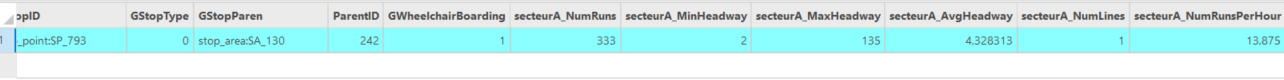